# Task 6.6 Sourcing & Analyzing Time Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [8]:
# Configure API key 

quandl.ApiConfig.api_key = 'MXDLFcXr-61Ky7v8EYtE' # import own API key here

In [13]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('RATEINF/CPI_DEU')

In [14]:
data.head(5)

,Value
Date,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


In [21]:
data.tail(5)

,Value
Date,
2022-12-31,113.2
2023-01-31,114.3
2023-02-28,115.2
2023-03-31,116.1
2023-04-30,116.6


In [15]:
data.shape

(388, 1)

In [16]:
data.columns

Index(['Value'], dtype='object')

In [17]:
type(data)

pandas.core.frame.DataFrame

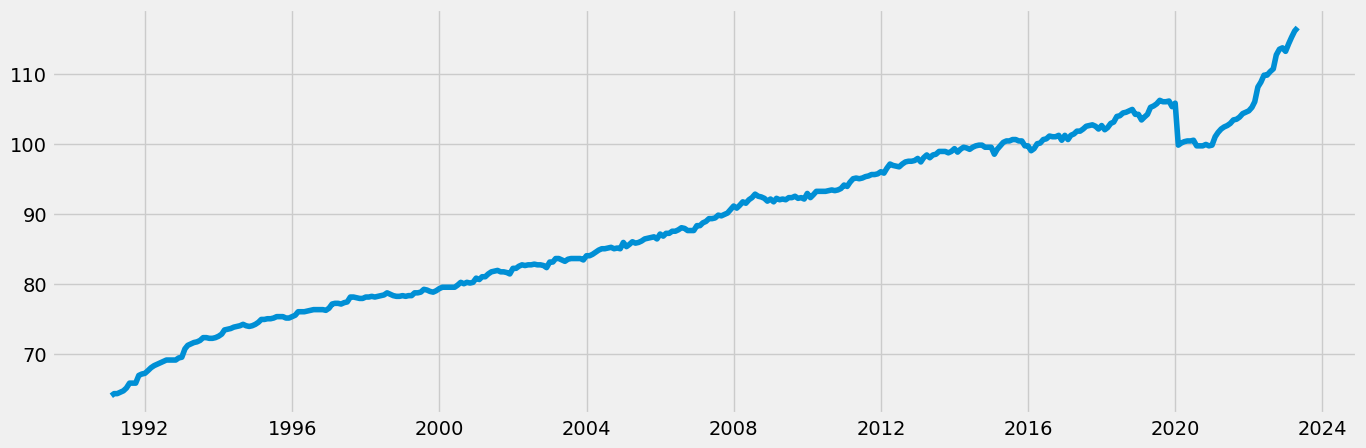

In [18]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [34]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [35]:
data_2.head()

,Date,Value
0,1991-01-31,64.0
1,1991-02-28,64.3
2,1991-03-31,64.3
3,1991-04-30,64.5
4,1991-05-31,64.7


In [36]:
data_sub = data_2.loc[(data_2['Date'] >= '2010-01-01') & (data_2['Date'] < '2019-12-31')]

In [37]:
data_sub.shape

(119, 2)

#
to be able to compare rental prices from my achievement with the consumer price index in Germany I have chosen to create a subset of the data. I have excluded data after end of 2019 as my rental analysis contains data that goes until 2019 and the pandemic in the following year will have impaceted the price index, which will not yet have been reflected in the housing market.
Additionally I capped the data at 2010 as more historic data will would not be relevant to the housing market today, I did however want to still have a substantial amount of data to use, so capping it later would have made the data set too small

In [38]:
data_sub.head()

,Date,Value
228,2010-01-31,92.3
229,2010-02-28,92.7
230,2010-03-31,93.2
231,2010-04-30,93.2
232,2010-05-31,93.2


In [39]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2010-01-31,92.3
2010-02-28,92.7
2010-03-31,93.2
2010-04-30,93.2
2010-05-31,93.2


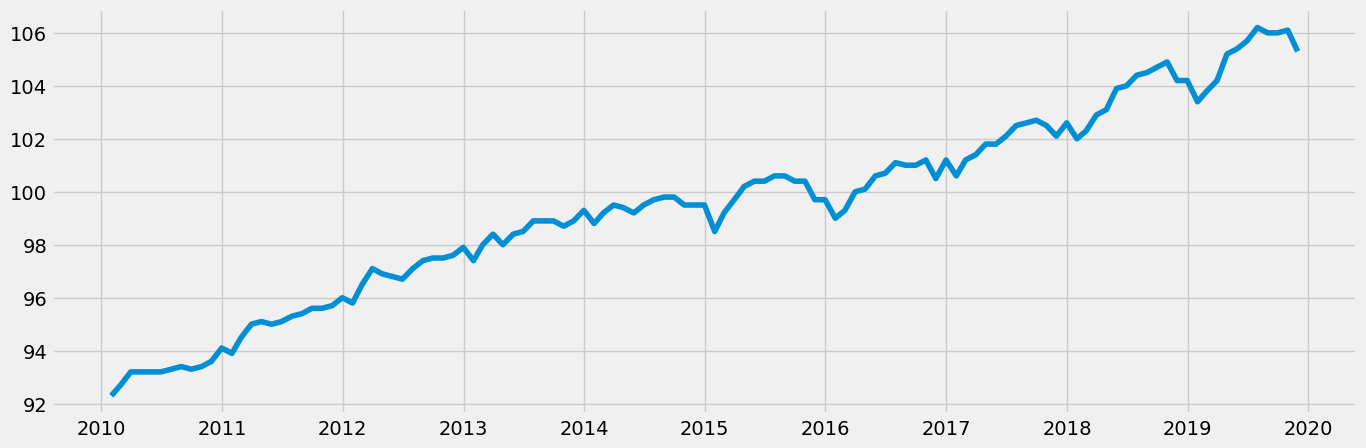

In [40]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [41]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [42]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# 44 duplicates

44

In [44]:
dups = data_sub[data_sub.duplicated()]

In [48]:
dups.head(5)

,Value
datetime,
2010-04-30,93.2
2010-05-31,93.2
2010-06-30,93.2
2010-09-30,93.3
2010-10-31,93.4


#
duplicates were not removed as they are the same value, but not on the same date, so no true duplicates

### 3. Time-series analysis: decomposition

In [49]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [50]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

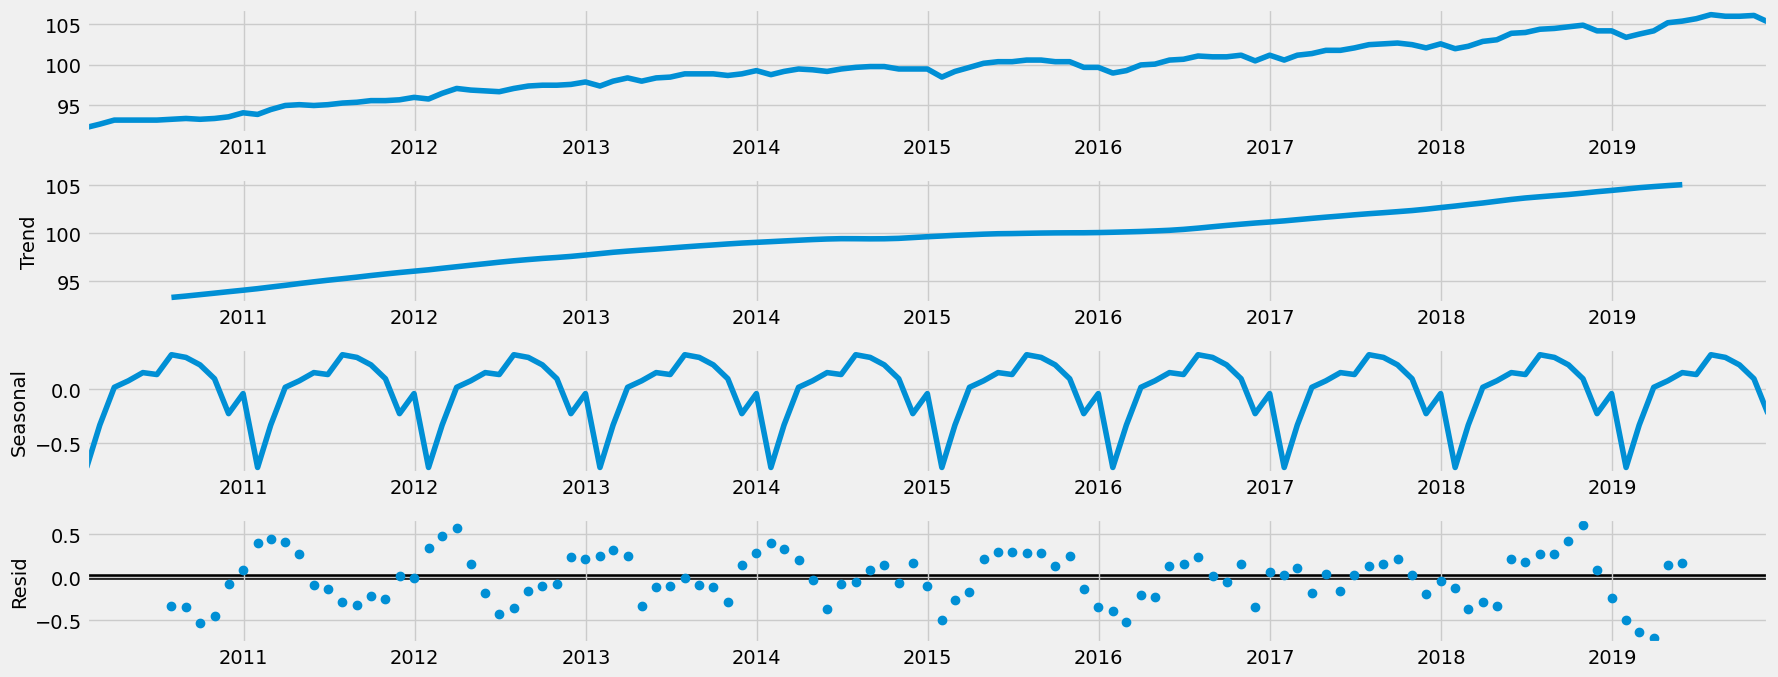

In [51]:
# Plot the separate components

decomposition.plot()
plt.show()

#
the trendline shows us a steady increase over the yeary, flattening out around 2015 and then increasing again mid 2016. The upward trend indicates that the data is not stationary. 
We can also see a seasonality a and a fair amount of noise.

### 4. Testing for stationarity

In [52]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.605841
p-value                          0.869657
Number of Lags Used             13.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


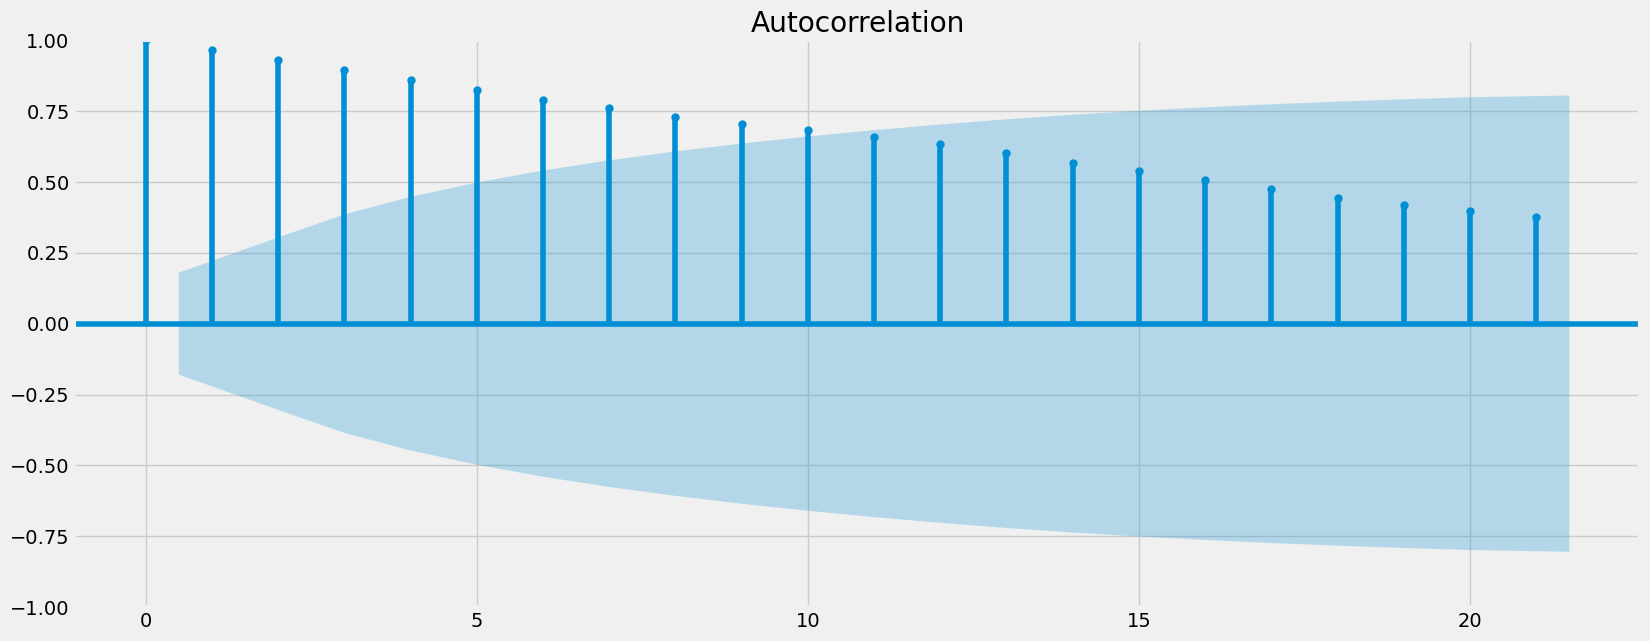

In [53]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

#

The Test statistic is lager than the critical values, so we cannot reject the null hypothisis, which means there is a unit root in the that and the data is, as expected, non stationary.
Additionally we can see that there are lags that beyond the confidence interval, which means they are significantley correlated with each other and thereby also indicate tht data is non stationary


### 5. Stationarizing the Federal Reserve Economic Data

In [54]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [55]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [56]:
data_diff.head()

,Value
datetime,
2010-02-28,0.4
2010-03-31,0.5
2010-04-30,0.0
2010-05-31,0.0
2010-06-30,0.0


In [57]:
data_diff.columns

Index(['Value'], dtype='object')

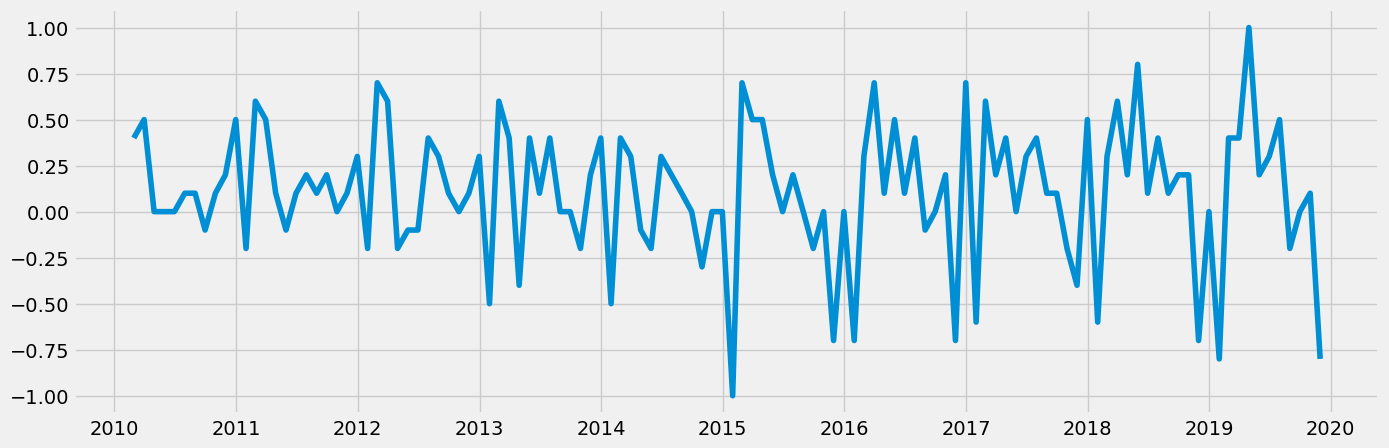

In [58]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [59]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.920529
p-value                          0.322466
Number of Lags Used             12.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


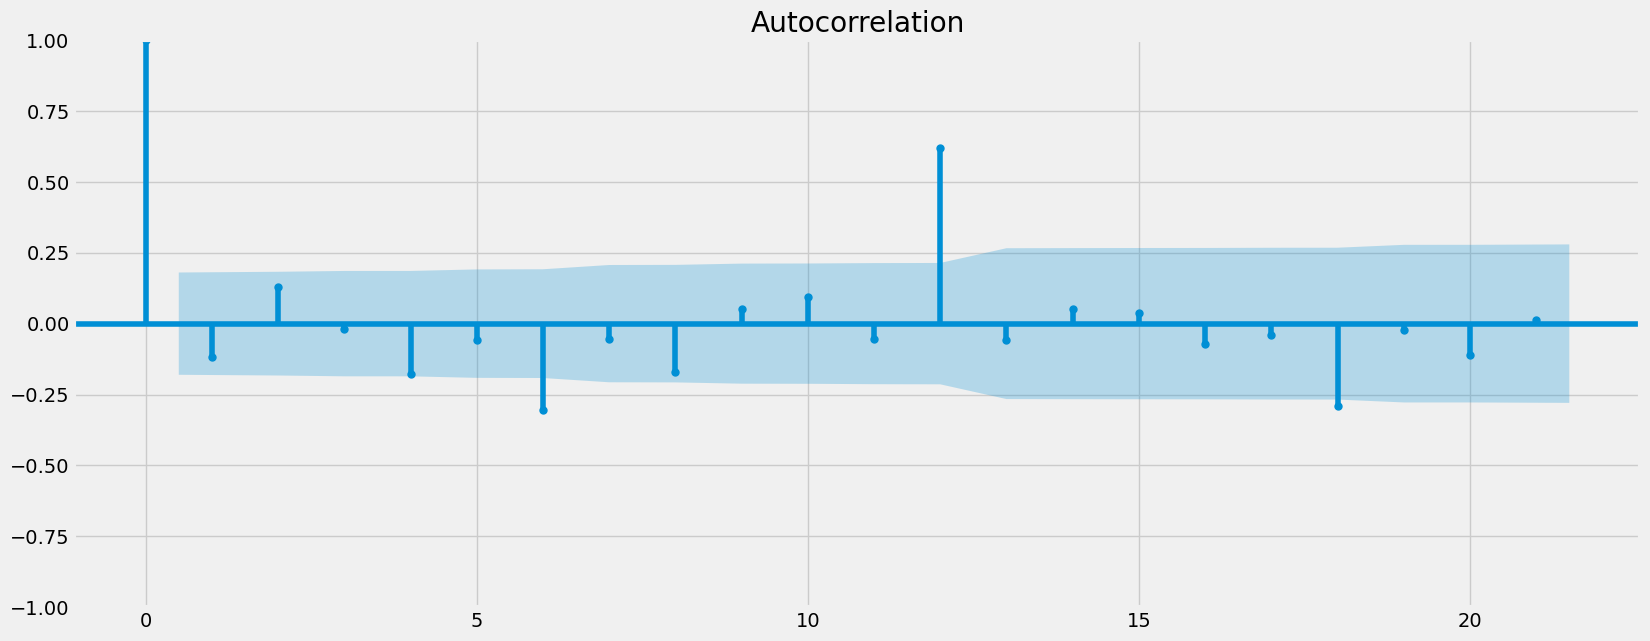

In [60]:
plot_acf(data_diff)
plt.show()

# 
with the test statistiv still being lower thatn the critical values another round will neeed to be done

In [62]:
data_diff_2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [63]:
data_diff_2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

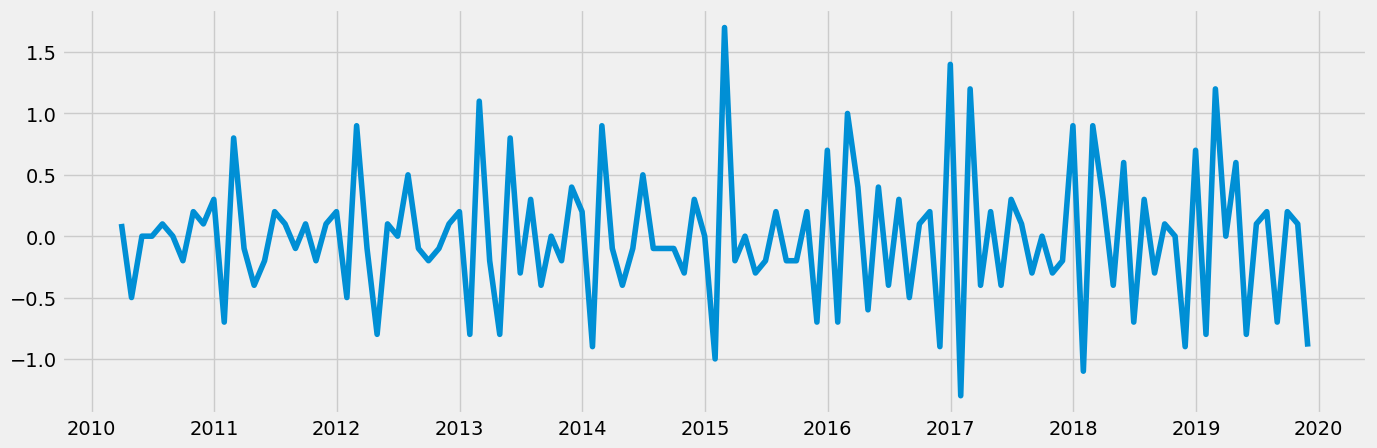

In [64]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [65]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.498066e+00
p-value                        3.505080e-16
Number of Lags Used            1.100000e+01
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64


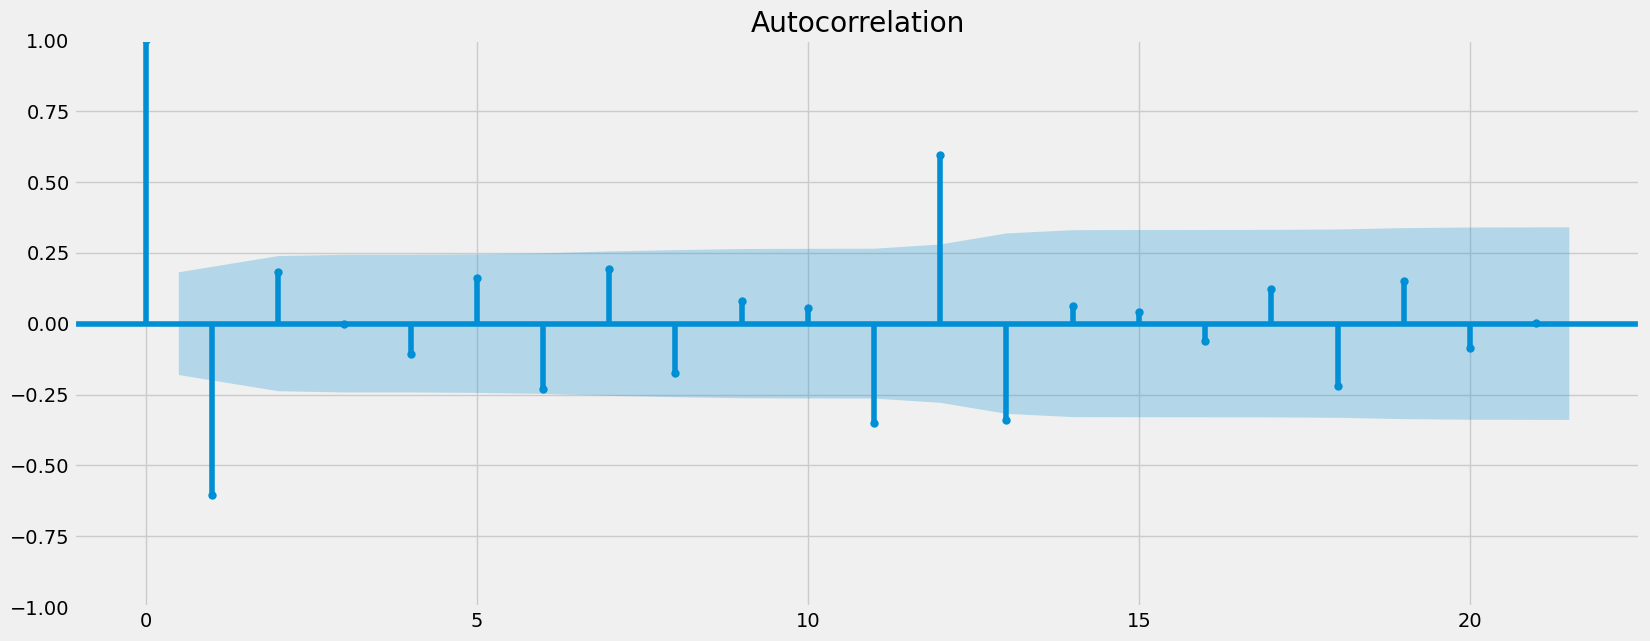

In [66]:
plot_acf(data_diff_2)
plt.show()